In [1]:
%matplotlib inline

# Data analysis

In this notebook you will find:
- Necessary imports
- Participant age information
- Number of dyslexic parents
- Function to calculate the average erp per class (risk/no risk)
- Frequency domain features
- Connectivity with stimulus and without 

Note: Make sure you run the data analysis notebook before to have the right paths in the `metadata.csv`!

# Imports

Below are the necessary imports for this notebook. mne_connectivity still needs to be added to the environment. 

In [2]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from math import nan

# Make sure that the 5 imports below are all installed using pip install ... 
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_sensors_connectivity
import pyvista 
import mayavi
import vtk

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import initialization_functions #library to import data
import epod_helper

The newest version of mne is necessary to run connectivity plots. If you don't have the latest version, uncomment and run the line below.

In [3]:
# pip install git+https://github.com/mne-tools/mne-python.git

## Load metadata and epochs

In the notebook `data_prep_eeg.ipynb` a csv-file `metadata.csv` is created. It is saved in the same folder as this notebook. The csv contains information about the participants and the corresponding eeg and epoch files. 

In [4]:
metadata = pd.read_csv('metadata.csv', sep = ',')

In [5]:
metadata

,eeg_file,ParticipantID,test,sex,age_months,age_months_days,dyslexic_parent,Group_AccToParents,path_eeg,path_epoch,path_eventmarkers,epoch_file
0,101a,101,a,m,20,20;22,m,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ep...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ev...,101a_epo.fif
1,101b,101,b,m,23,23;16,m,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ep...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ev...,101b_epo.fif
2,102a,102,a,f,20,20;27,Nee,Control,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ep...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ev...,102a_epo.fif
3,102b,102,b,f,23,23;16,Nee,Control,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ep...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ev...,102b_epo.fif
4,103a,103,a,f,20,20;23,m,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ep...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ev...,103a_epo.fif
...,...,...,...,...,...,...,...,...,...,...,...,...
173,194a,194,a,f,19,19;0,f,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ep...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ev...,194a_epo.fif
174,194b,194,b,f,22,22;3,f,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ep...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ev...,194b_epo.fif
175,195a,195,a,f,18,18;10,f,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ep...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ev...,195a_epo.fif
176,211a,211,a,m,18,18;27,m,At risk,F:\Stage\ePODIUM\Data\ePodium_projectfolder\Da...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ep...,F:\Stage\ePODIUM\Data\ePodium_projectfolder\ev...,211a_epo.fif


The epochs can be read from the directed paths stored in the metadata. The function below loads all files into a list called `epochs`.

In [6]:
def read_filtered_data(metadata):
    epochs = []
    for index, file in metadata.iterrows():
        print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False)
        epochs.append(epoch)
    return epochs

<font color = 'blue'> Review: tip of the 'trade': learn to use .apply() as in pandas.Dataframe.apply() to process a whole dataframe, it's more optimized for being fast</font>

In [7]:
epochs = read_filtered_data(metadata)

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 101b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\101b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 102a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\102a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2389 matching events found
No baseline correction applied
0 projection items activ

        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 115b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\115b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 116a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\116a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2343 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 116b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\116b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.2

Checking out file: 130a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\130a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 130b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\130b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 131a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\131a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activ

        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 143a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\143a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 143b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\143b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
1051 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 144a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\144a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.2

    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 158a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\158a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 159a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\159a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 159b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\159b_epo.fif

No baseline correction applied
0 projection items activated
Checking out file: 170b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\170b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 171a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\171a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 171b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\171b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events f

    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 179b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\179b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2487 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 180a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\180a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 180b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\180b_epo.fif

No baseline correction applied
0 projection items activated
Checking out file: 193b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\193b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2441 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 194a_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\194a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events found
No baseline correction applied
0 projection items activated
Checking out file: 194b_epo.fif
Reading F:\Stage\ePODIUM\Data\ePodium_projectfolder\epochs\194b_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2440 matching events f

## Single participant information

Choose which participant you want to view in the box below. 

In [8]:
index = widgets.IntText(
    step=0.1,
    description='Participant',
    disabled=False
)
widgets.VBox([index])

In [9]:
index = int(index.value)

below files can be dropped, since they do not contain all the events. 

In [10]:
drop_files = ["113a", "107b (deel 1+2)", "132a", "121b(2)", "113b", "107b (deel 3+4)", "147a",
                "121a", "134a", "143b", "121b(1)", "145b", "152a", "184a", "165a", "151a", "163a", "179a","179b", "182b", "186a", "193b"]

metadata = metadata[~metadata['eeg_file'].isin(drop_files)]

### Visualize raw eeg 

In [11]:
path_eeg = os.path.join(metadata['path_eeg'][index], metadata['eeg_file'][index] + '.bdf')
eeg = mne.io.read_raw_bdf(path_eeg, preload=False)

Extracting EDF parameters from F:\Stage\ePODIUM\Data\ePodium_projectfolder\Dataset\101a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


Using matplotlib as 2D backend.
Opening raw-browser...


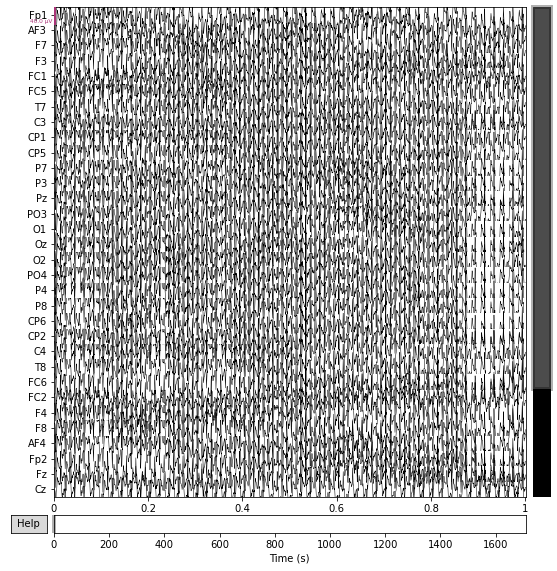

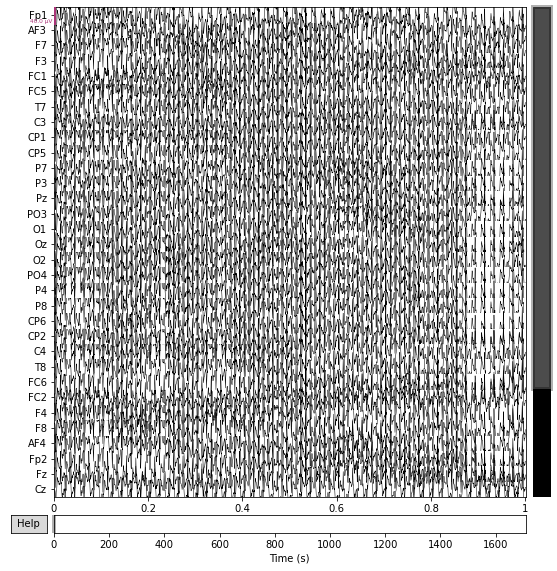

In [12]:
eeg.plot(duration=1, n_channels=32)

In [13]:
path_event = os.path.join(metadata['path_eventmarkers'][index], metadata['eeg_file'][index] + '.txt') 
event_markers = np.loadtxt(path_event, dtype=int)
event_markers_simplified = epod_helper.group_events_12(event_markers) # simplify events

<ipython-input-14-56f5d4ef35c7>:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(event_markers_simplified, event_id = epod_helper.event_dictionary)


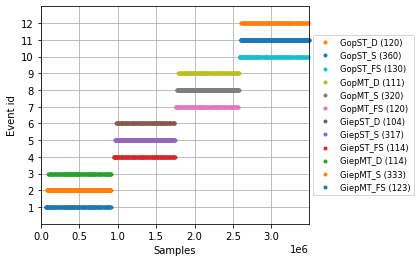

In [14]:
%matplotlib inline 
fig = mne.viz.plot_events(event_markers_simplified, event_id = epod_helper.event_dictionary)

<font color ='blue'> Review: you can deal with the warning, by just passing a list, and it will make this better! you can pass the list in hexadecimals</font>

### Vizualize epochs and evoked responses

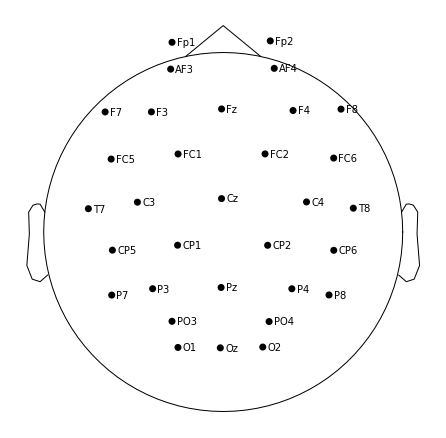

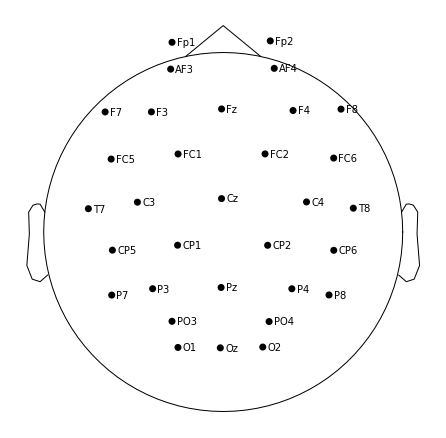

In [15]:
epochs[index].plot_sensors(ch_type='eeg', show_names=True)

Evoked responses are created by averaging the epochs for a specific event. The function therefore needs as input the created `epochs` and `event_dictionary` containing the different types of events used in the experiment. 

In [16]:
event_dictionary = epod_helper.event_dictionary
evoked = hf.evoked_responses(epochs[index], event_dictionary)

Below each event is plotted for a single subject with the average for each channel. 

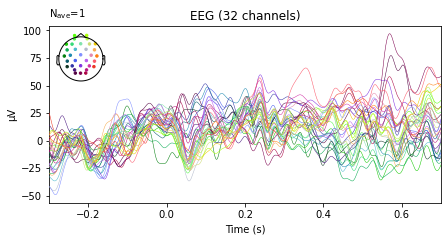

('GiepMT_FS', 1)


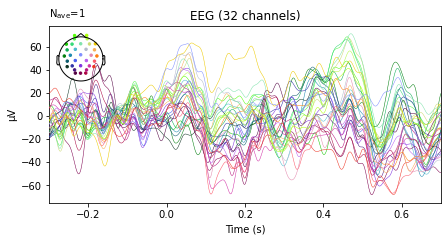

('GiepMT_S', 2)


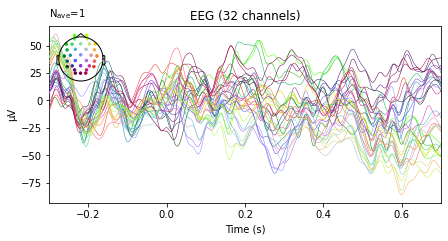

('GiepMT_D', 3)


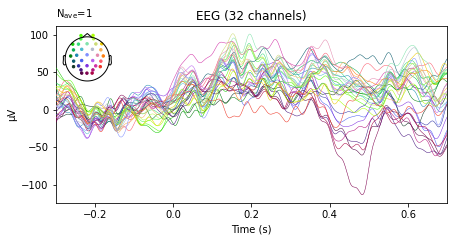

('GiepST_FS', 4)


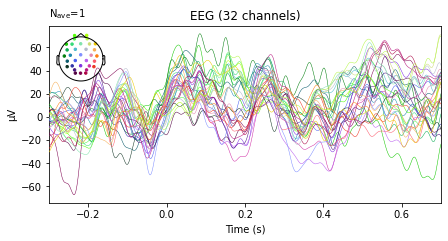

('GiepST_S', 5)


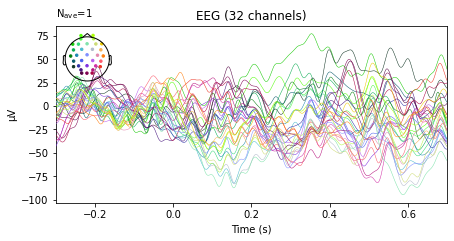

('GiepST_D', 6)


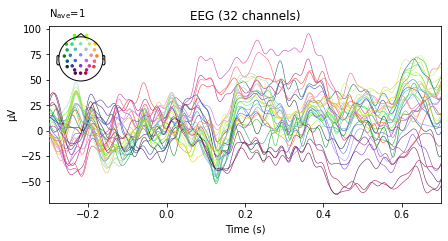

('GopMT_FS', 7)


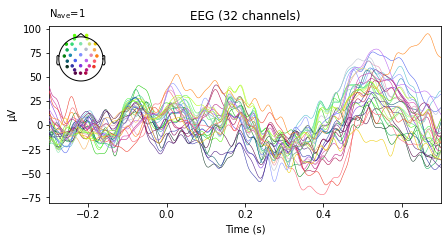

('GopMT_S', 8)


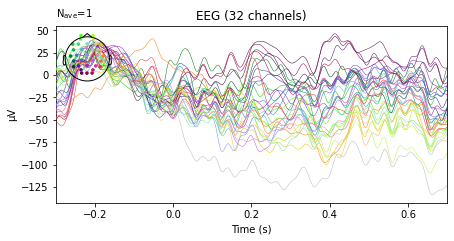

('GopMT_D', 9)


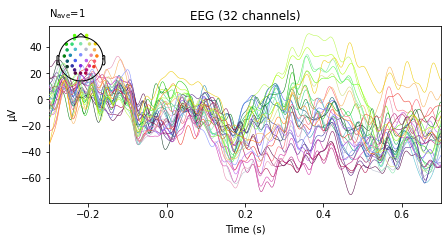

('GopST_FS', 10)


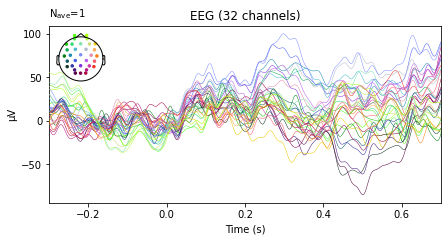

('GopST_S', 11)


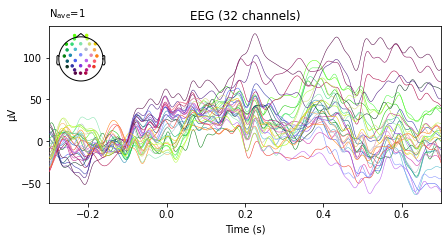

('GopST_D', 12)


In [17]:
for i in range(len(event_dictionary)):
    evoked[i].plot(spatial_colors=True, exclude='bads')
    print(([key for key in epod_helper.event_dictionary.keys()][i], [value for value in epod_helper.event_dictionary.values()][i]))

The grand average is calculated by the average response on all events combined for each channel. 

Identifying common channels ...


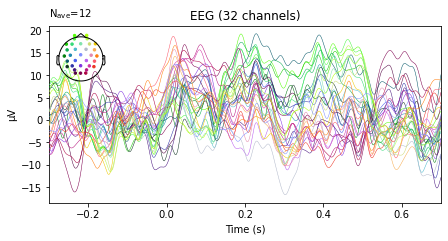

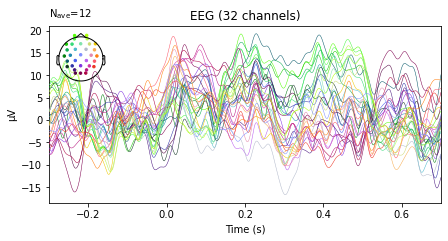

In [18]:
ga_singlesub = mne.grand_average(evoked)
ga_singlesub.plot(spatial_colors=True)

We will now only look at the standard events, which are events 2, 5, 8 and 11. The first standards were removed, since the participant need some time to adjust to the standard not being 'new' anymore. The deviant events differ from the standard one and are 3, 6, 9 and 12. First, the average per channel for the standard and deviant is calculated and plotted. The second plots shows the mean over all channels between the standard and deviant. 

Need more than one channel to make topography for eeg. Disabling interactivity.


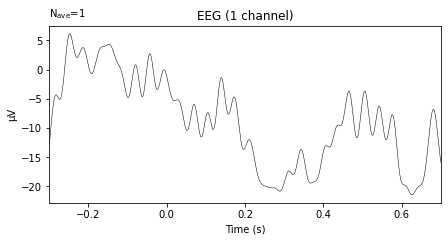

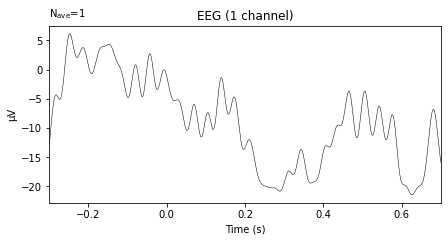

In [19]:
std_evoked = epochs[index][2,5,8,11].average()
dev_evoked = epochs[index][3,6,9,12].average()

evoked_diff = mne.combine_evoked([std_evoked, dev_evoked], weights=[1, -1])

chnames = evoked_diff.info['ch_names']
chnames = mne.pick_channels(evoked_diff.info['ch_names'], include=chnames)
roi_dict = dict(left_ROI=chnames)
roi_evoked = mne.channels.combine_channels(evoked_diff, roi_dict, method='mean')
roi_evoked.plot()

Deviant
Need more than one channel to make topography for eeg. Disabling interactivity.


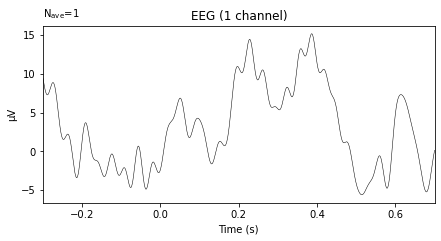

Standard
Need more than one channel to make topography for eeg. Disabling interactivity.


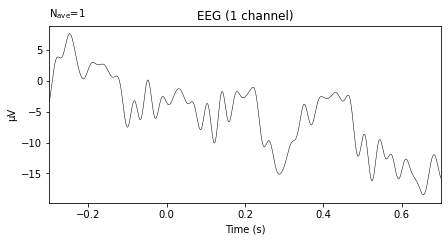

mismatch response
Need more than one channel to make topography for eeg. Disabling interactivity.


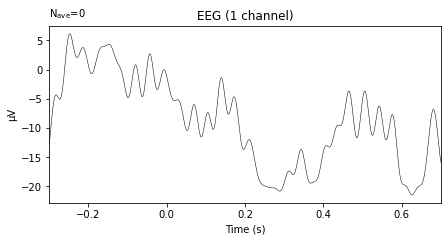

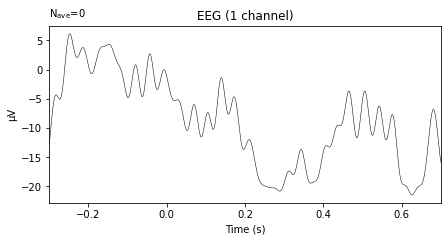

In [20]:
chnames = evoked_diff.info['ch_names']
chnames_dev = dev_evoked.info['ch_names']

chnames_std = mne.pick_channels(std_evoked.info['ch_names'], include=chnames)
chnames_dev = mne.pick_channels(dev_evoked.info['ch_names'], include=chnames_dev)

roi_dict = dict(left_ROI=chnames_std)
roi_evoked_dev = mne.channels.combine_channels(dev_evoked, roi_dict, method='mean')
print("Deviant") 
roi_evoked_dev.plot()
roi_evoked_std = mne.channels.combine_channels(std_evoked, roi_dict, method='mean')
print("Standard")
roi_evoked_std.plot()
evoked_diff = mne.combine_evoked([roi_evoked_std, roi_evoked_dev], weights=[1, -1])
print("mismatch response")
evoked_diff.plot()

combining channels using "mean"
combining channels using "mean"


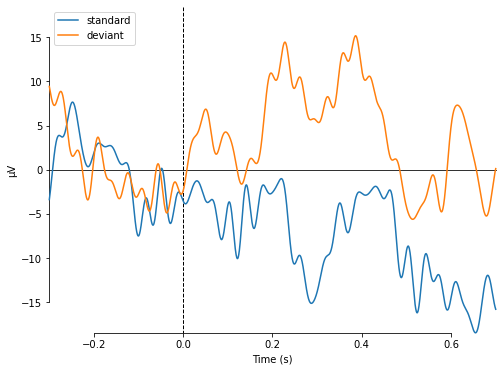

[<Figure size 576x432 with 1 Axes>]

In [21]:
evokeds = dict(standard=std_evoked, deviant=dev_evoked)
mne.viz.plot_compare_evokeds(evokeds, combine='mean')

## All participant information

In [22]:
metadata['Group_AccToParents'].count(by='Group_AccToParents')

TypeError: count() got an unexpected keyword argument 'by'

The value to classify will be whether the participant is at risk for dyslexia or not. The age distribution for both groups is plotted below.

In [ ]:
hist = metadata.hist(column='age_months',by='Group_AccToParents',color='#12ABDB',sharex=True, figsize=(8,5), xlabelsize=11, ylabelsize=11,bins=10,ec='black')
metadata['age_months'].describe()

Count of the gender for both groups. 

In [ ]:
metadata.groupby('Group_AccToParents')['sex'].value_counts()

Count of whether the mom or dad is dyslexic or not. 

In [ ]:
metadata.groupby('Group_AccToParents')['dyslexic_parent'].value_counts()

## ERP per group

This function is able to calculate the average erp for a specific condition. The function needs a dataframe like `metadata.csv` which contains the epoch files and the participants characteristics. It also needs as input the characteristic we are interested in and a single value of this characteristic. For example if we want to look at the average erp for the children who are at risk, the group will be the column (feature) containing the values at risk or control and the value will be 'at risk'. The function also needs the event dictionary in order to average the epochs over multiple participants. 

In [25]:
event_dictionary = epod_helper.event_dictionary

def data_analysis(dataframe, group, value, event_dictionary):
    epochs = []
    evoked_pp = []
    dataframe = dataframe.loc[metadata[group] == value]
    evokeds = []
    filenames = []
    
    for index, file in dataframe.iterrows():
        print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False)
        epochs.append(epoch)
        filenames.append(file['epoch_file'])
    
    for i in range(len(epochs)): 
        print(filenames[i])
        evoked = hf.evoked_responses(epochs[i], event_dictionary)
        evokeds.append(evoked)
    
    for i in range(len(evokeds)):
        grand_avg = mne.grand_average(evokeds[i])
        evoked_pp.append(grand_avg)
    
    grand_evoked = mne.grand_average(evoked_pp)
    
    return grand_evoked.plot(spatial_colors=True)

101a_epo.fif
101b_epo.fif
103a_epo.fif
103b_epo.fif
104a_epo.fif
104b_epo.fif
105a_epo.fif
105b_epo.fif
106a_epo.fif
106b_epo.fif
107a_epo.fif
109a_epo.fif
109b_epo.fif
110a_epo.fif
110b_epo.fif
111a_epo.fif
112a_epo.fif
112b_epo.fif
114a_epo.fif
114b_epo.fif
115a_epo.fif
115b_epo.fif
116a_epo.fif
116b_epo.fif
122b_epo.fif
123a_epo.fif
123b_epo.fif
125a_epo.fif
125b_epo.fif
128a_epo.fif
128b_epo.fif
129a_epo.fif
129b_epo.fif
130a_epo.fif
130b_epo.fif
137a_epo.fif
137b_epo.fif
140a_epo.fif
140b_epo.fif
141a_epo.fif
142a_epo.fif
142b_epo.fif
148a_epo.fif
148b_epo.fif
149a_epo.fif
152b_epo.fif
155a_epo.fif
155b_epo.fif
156a_epo.fif
156b_epo.fif
157a_epo.fif
157b_epo.fif
158a_epo.fif
159a_epo.fif
159b_epo.fif
160a (2)_epo.fif
160a_epo.fif
160b_epo.fif
161a_epo.fif
161b_epo.fif
162a_epo.fif
162b_epo.fif
163b_epo.fif
164a_epo.fif
164b_epo.fif
165b_epo.fif
213a_epo.fif
214a_epo.fif
217a_epo.fif
219a_epo.fif
178a_epo.fif
181a_epo.fif
181b_epo.fif
182a_epo.fif
188a_epo.fif
188b_epo.fif
190a_epo

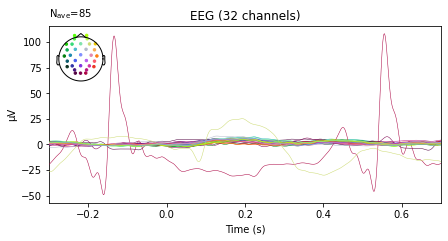

In [26]:
atrisk = data_analysis(metadata, group='Group_AccToParents', value = 'At risk', event_dictionary = epod_helper.event_dictionary)

In [ ]:
control = data_analysis(metadata, group='Group_AccToParents', value = 'Control', event_dictionary = epod_helper.event_dictionary)

In [ ]:
test_a = data_analysis(metadata, group='test', value = 'a', event_dictionary = epod_helper.event_dictionary)

In [ ]:
test_b = data_analysis(metadata, group='test', value = 'b', event_dictionary = epod_helper.event_dictionary)

## Connectivity 

In [ ]:
dataframe = metadata
epochs = []
for index, file in dataframe.iterrows():
    print(f"Checking out file: {file['epoch_file']}")
    path = os.path.join(file['path_epoch'], file['epoch_file'])
    epoch = mne.read_epochs(path, preload=False)
    epochs.append(epoch)

Computing eeg connectivity

In [ ]:
def data_connectivity(dataframe, group, value):
    epochs = []
    dataframe = dataframe.loc[metadata[group] == value]
    
    for index, file in dataframe.iterrows():
        print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False)
        epochs.append(epoch)
    
    epochs_con = mne.concatenate_epochs(epochs)
    
    fmin, fmax = 4., 9.
    sfreq = epochs_con.info['sfreq']  # the sampling frequency
    tmin = 0.0  # exclude the baseline period
    
    con = spectral_connectivity_epochs(
        epochs_con, method='pli', mode='multitaper', fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

    # Now, visualize the connectivity in 3D:
    
    return plot_sensors_connectivity(epochs_con.info, con.get_data(output='dense')[:, :, 0]), spectral_connectivity_epochs(
        epochs_con, method='pli', mode='multitaper', fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

In [ ]:
connectivityplot_atrisk, connections_atrisk = data_connectivity(metadata, group='Group_AccToParents', value = 'At risk')

In [ ]:
connections_atrisk = connections_atrisk.get_data(output='dense')[:, :, 0]
matrix = pd.DataFrame(connections_atrisk)
matrix

In [ ]:
connectivityplot_control, connections_control = data_connectivity(metadata, group='Group_AccToParents', value = 'Control')

In [ ]:
connections_control = connections_control.get_data(output='dense')[:, :, 0]
matrix = pd.DataFrame(connections_control)
matrix

<font color= 'blue'>Important note: In the above blocks I see three places you are essentially doing a similar or same code block to dataprep_eeg. This is what calls out to become a function in the common library! Whenever you are repeating a code block ask youself why</font>